In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt

droit = pd.read_csv("C:/Users/antho/Documents/Digisport/Semestre_3/Projet_kayak/data/Pagaie_droite.csv", delimiter= ",", skiprows=6, header=0)
gauche = pd.read_csv("C:/Users/antho/Documents/Digisport/Semestre_3/Projet_kayak/data/Pagaie_gauche.csv", delimiter= ",", skiprows=6, header=0)
milieu = pd.read_csv("C:/Users/antho/Documents/Digisport/Semestre_3/Projet_kayak/data/Pagaie_milieu.csv", delimiter= ",", skiprows=6, header=0)
bateau = pd.read_csv("C:/Users/antho/Documents/Digisport/Semestre_3/Projet_kayak/data/Dot_Bateau.csv", delimiter= ",", skiprows=6, header=0)

# Calcul du temps

In [55]:
# Convertir la colonne 'SampleTimeFine' en minutes
droit['Time'] = (droit['SampleTimeFine'] - droit['SampleTimeFine'].min()) / 60000000.0
gauche['Time'] = (gauche['SampleTimeFine'] - gauche['SampleTimeFine'].min()) / 60000000.0
milieu['Time'] = (milieu['SampleTimeFine'] - milieu['SampleTimeFine'].min()) / 60000000.0
bateau['Time'] = (bateau['SampleTimeFine'] - bateau['SampleTimeFine'].min()) / 60000000.0


In [56]:
print(droit)

       PacketCounter  SampleTimeFine     Euler_X    Euler_Y     Euler_Z  \
0                  0       213102203   82.562790  -3.938358  166.842468   
1                  1       213118870   82.582016  -3.936672  166.867554   
2                  2       213135537   82.598297  -3.932262  166.832321   
3                  3       213152204   82.632347  -3.924868  166.845718   
4                  4       213168871   82.666306  -3.912875  166.784195   
...              ...             ...         ...        ...         ...   
97666          97666      1840901425 -169.681290  78.316055   29.061100   
97667          97667      1840918092 -169.676315  78.315636   29.066238   
97668          97668      1840934759 -169.679138  78.315056   29.063452   
97669          97669      1840951426 -169.679230  78.314827   29.063240   
97670          97670      1840968093 -169.678726  78.315323   29.062725   

          Acc_X     Acc_Y     Acc_Z     Gyr_X     Gyr_Y     Gyr_Z       Time  
0      0.000000  0.0

# Comparaison gauche et droite

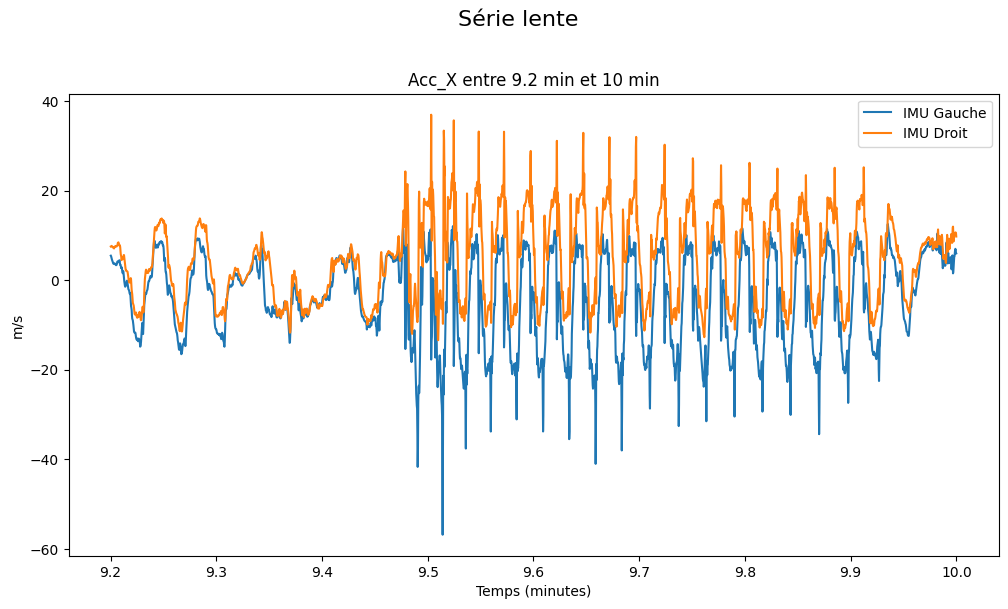

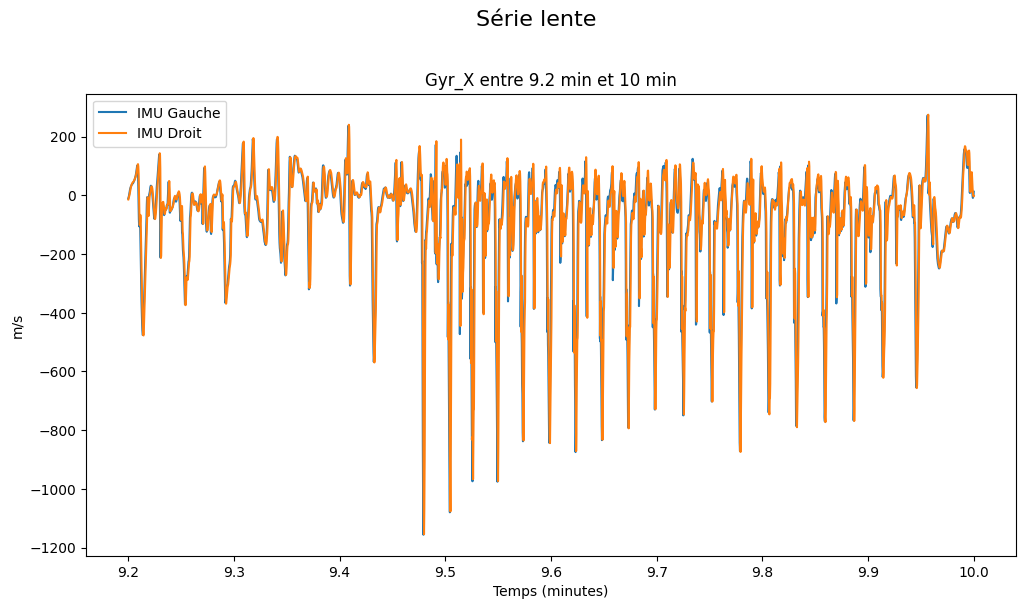

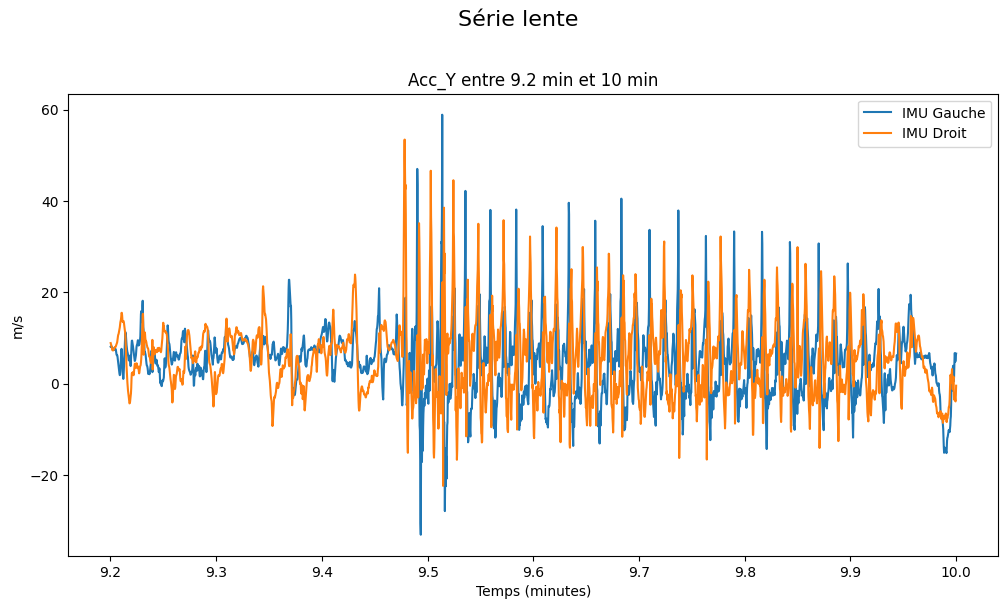

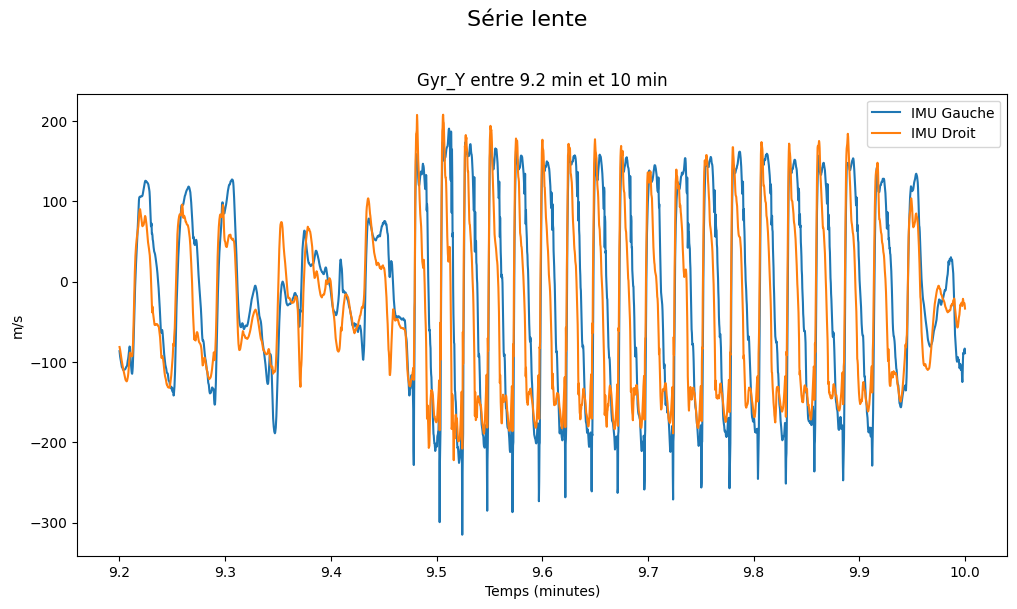

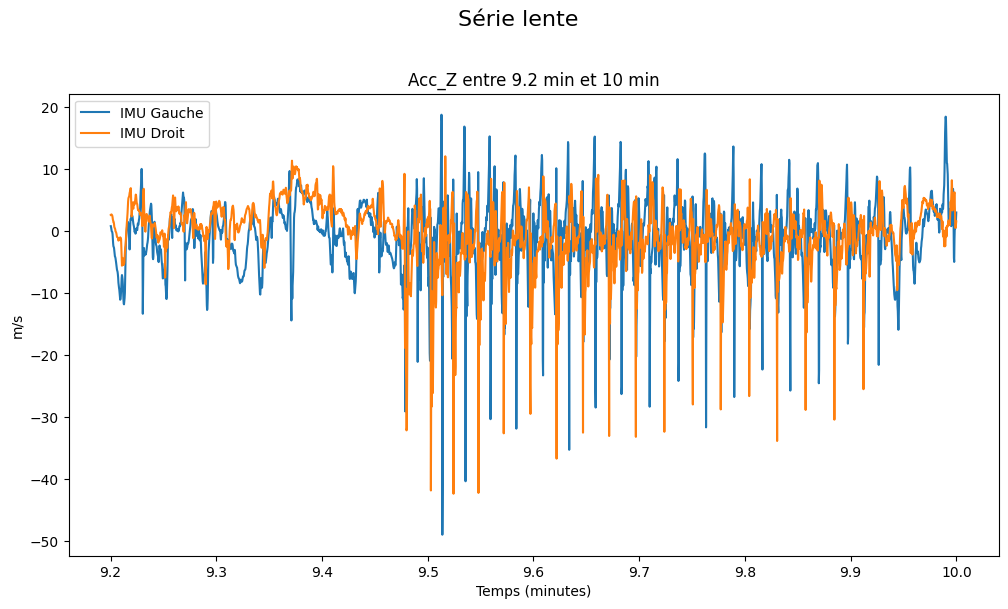

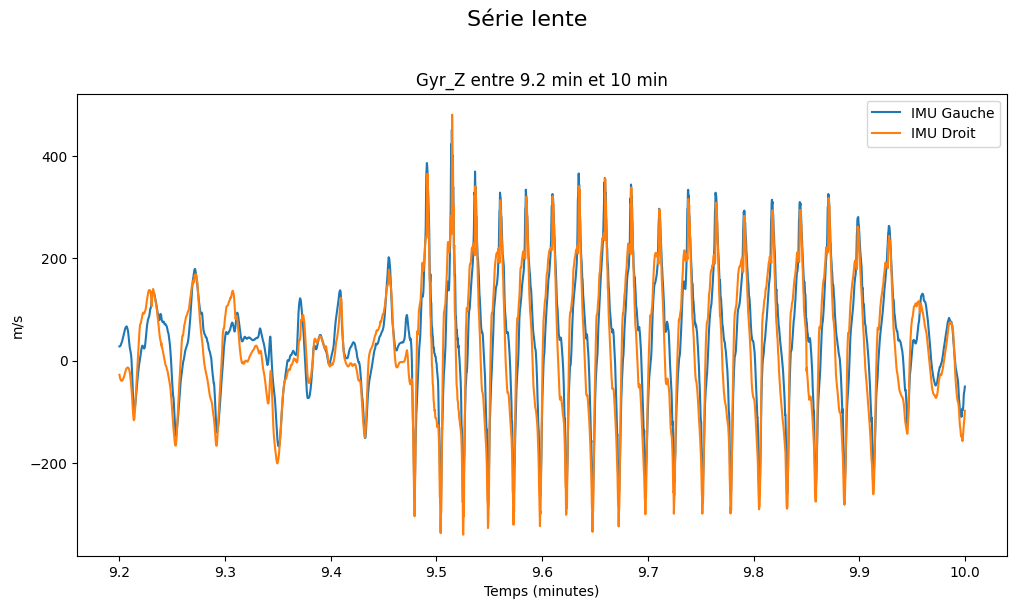

In [4]:
def compare_sides(df_left, df_right, variable, start_time, end_time, series_title=""):
    """
    Compare les deux côtés d'un DataFrame pour une variable spécifiée dans un intervalle donné.

    Paramètres :
    - df_left : DataFrame pour le côté gauche
    - df_right : DataFrame pour le côté droit
    - df_milieu : DataFrame pour le côté milieu
    - variable : Nom de la variable à comparer
    - start_time : Temps de début de l'intervalle
    - end_time : Temps de fin de l'intervalle
    - series_title : Titre de la série ("Série lente", "Série modérée", "Série rapide")
    """
    
    # Filtrer les données en fonction des temps spécifiés
    df_left_filtered = df_left[(df_left['Time'] >= start_time) & (df_left['Time'] <= end_time)]
    df_right_filtered = df_right[(df_right['Time'] >= start_time) & (df_right['Time'] <= end_time)]
    #df_milieu_filtered = df_milieu[(df_milieu['Time'] >= start_time) & (df_milieu['Time'] <= end_time)]
    
    # Définir la taille de la figure
    plt.figure(figsize=(12, 6))  # Ajustez la taille selon vos besoins
    
    # Utiliser la même figure pour les deux graphiques
    plt.plot(df_left_filtered['Time'], df_left_filtered[variable], label='IMU Gauche')
    plt.plot(df_right_filtered['Time'], df_right_filtered[variable], label='IMU Droit')
    #plt.plot(df_milieu_filtered['Time'], df_milieu_filtered[variable], label='Milieu')
    
    # Ajouter une légende
    plt.legend()
    
    # Ajouter des titres et des étiquettes d'axe
    plt.title(f'{variable} entre {start_time} min et {end_time} min')
    plt.xlabel('Temps (minutes)')
    plt.ylabel('m/s')
    
    # Ajouter le titre de la série
    plt.suptitle(series_title, y=1.02, fontsize=16, ha="center")

    # Afficher le graphique
    plt.show()

#Série lentre = 8.5 à 11.50
#Série modérée = 12 à 14.50
#Série rapide = 15 à 20

compare_sides(gauche, droit, 'Acc_X', 9.2, 10, series_title="Série lente")
compare_sides(gauche, droit, 'Gyr_X', 9.2, 10, series_title="Série lente")
compare_sides(gauche, droit, 'Acc_Y', 9.2, 10, series_title="Série lente")
compare_sides(gauche, droit, 'Gyr_Y', 9.2, 10, series_title="Série lente")
compare_sides(gauche, droit, 'Acc_Z', 9.2, 10, series_title="Série lente")
compare_sides(gauche, droit, 'Gyr_Z', 9.2, 10, series_title="Série lente")

# Détection des pics

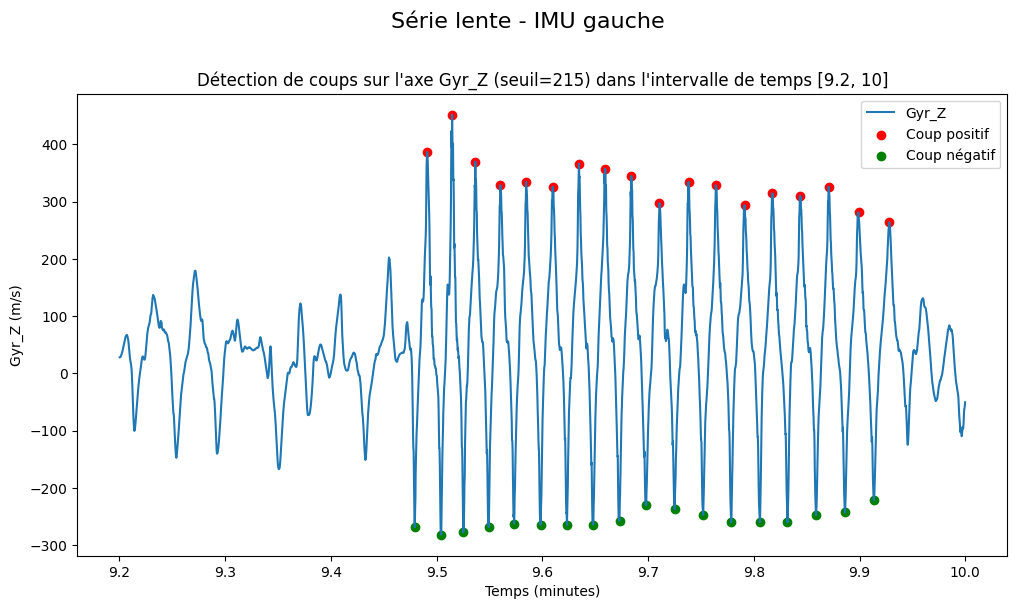

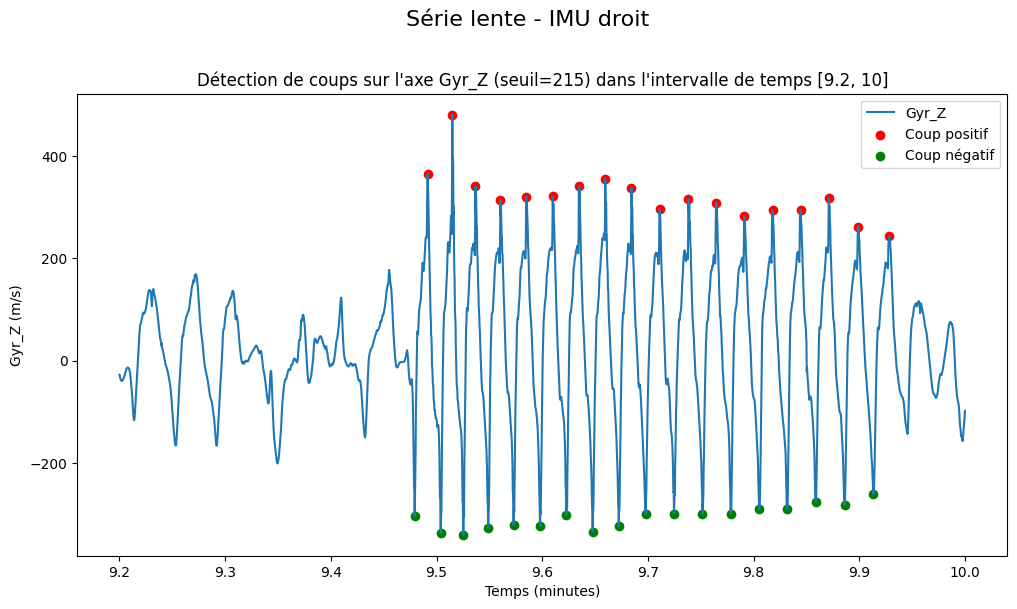

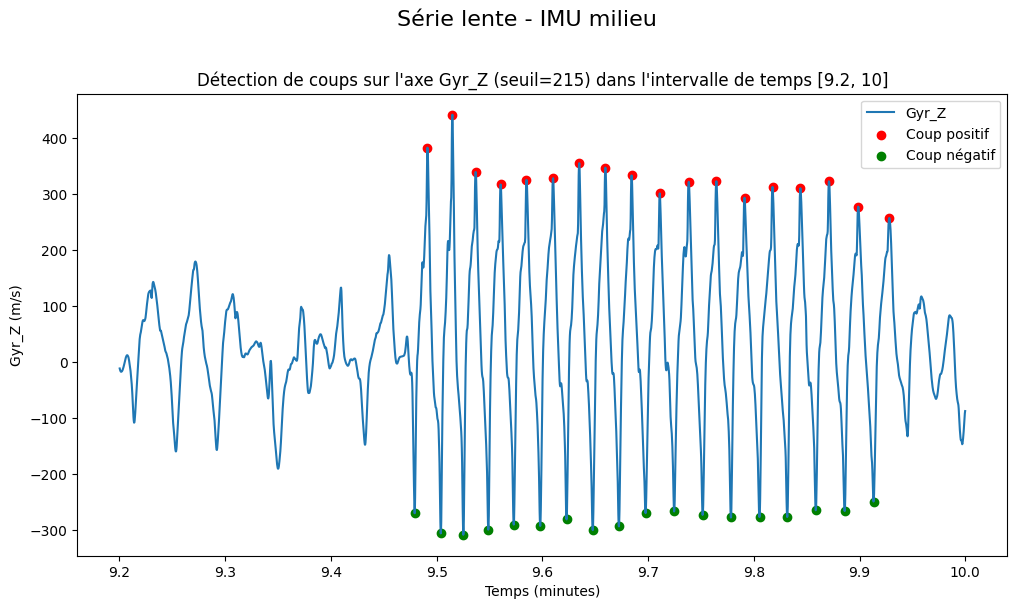

In [5]:
from scipy.signal import find_peaks

def detect_coup_in_interval(df, variable, seuil, start_time, end_time, prominence=220, distance=2, width=1, serie_title=""):
    """
    Détecte les coups sur un axe spécifié dans un intervalle de temps donné.

    Paramètres :
    - df : DataFrame contenant les données
    - variable : Nom de la variable à analyser (par exemple, 'Gyr_Z')
    - seuil : Seuil pour la détection des coups
    - start_time : Temps de début de l'intervalle
    - end_time : Temps de fin de l'intervalle
    - prominence : Paramètre de la fonction find_peaks (par défaut à 80)
    - distance : Paramètre de la fonction find_peaks (par défaut à 2)
    - width : Paramètre de la fonction find_peaks (par défaut à 1)
    - serie_title : Titre de la série ("Série lente", "Série modérée", "Série rapide")
    """
    
    # Filtrer les données en fonction de l'intervalle de temps spécifié
    df_filtered = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]
    
    # Identifier les pics dans la variable spécifiée
    peaks_positif, _ = find_peaks(df_filtered[variable], height=seuil, prominence=prominence, distance=distance, width=width)
    peaks_negatif, _ = find_peaks(-df_filtered[variable], height=seuil, prominence=prominence, distance=distance, width=width)

    # Plot des données avec les instants de coup mis en évidence
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered['Time'], df_filtered[variable], label=variable)
    plt.scatter(df_filtered['Time'].iloc[peaks_positif], df_filtered[variable].iloc[peaks_positif], color='red', label='Coup positif')
    plt.scatter(df_filtered['Time'].iloc[peaks_negatif], df_filtered[variable].iloc[peaks_negatif], color='green', label='Coup négatif')
    
    # Ajouter des titres et des étiquettes d'axe
    plt.title(f'Détection de coups sur l\'axe {variable} (seuil={seuil}) dans l\'intervalle de temps [{start_time}, {end_time}]')
    plt.xlabel('Temps (minutes)')
    plt.ylabel(f'{variable} (m/s)')
    
    # Ajouter une légende
    plt.legend()
    
    # Ajouter le titre de la série
    plt.suptitle(serie_title, y=1.02, fontsize=16, ha="center")
    
    # Afficher le graphique
    plt.show()

detect_coup_in_interval(gauche, 'Gyr_Z', 215, 9.2, 10, serie_title="Série lente - IMU gauche")
detect_coup_in_interval(droit, 'Gyr_Z', 215, 9.2, 10, serie_title="Série lente - IMU droit")
detect_coup_in_interval(milieu, 'Gyr_Z', 215, 9.2, 10, serie_title="Série lente - IMU milieu")

# Norme - Vitesse Bateau

In [6]:
# Calculer la norme de l'accélération
bateau['Norme_Acceleration'] = np.linalg.norm(bateau[['Acc_X', 'Acc_Y', 'Acc_Z']].values, axis=1)

# Filtre

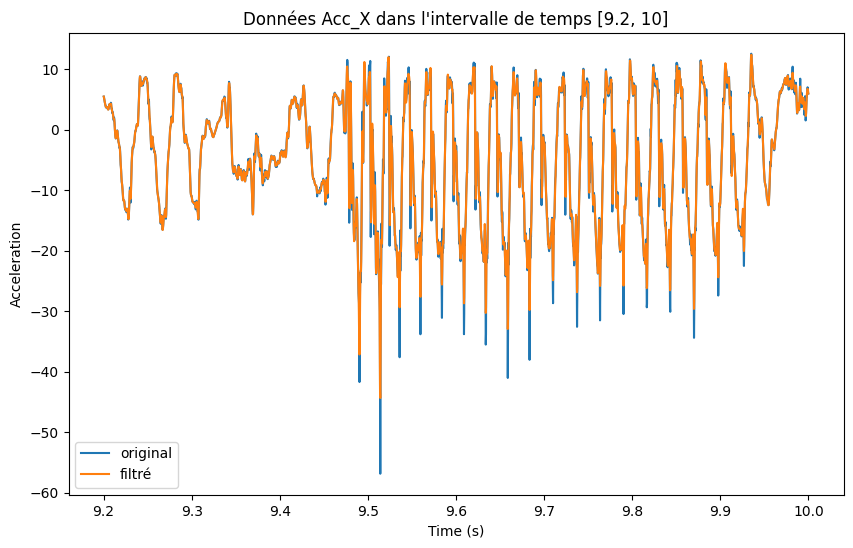

In [7]:

# Définir la fréquence d'échantillonnage
fs = 60.0

# Fonction pour créer le filtre passe-bas
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Fonction pour appliquer le filtre passe-bas aux données
def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Définir la fréquence de coupure du filtre (en Hz)
cutoff_frequency = 10.0

# Sélectionner un intervalle de temps (en secondes)
start_time = 9.2
end_time = 10

# Filtrer les données d'accélération dans l'intervalle de temps spécifié
filtered_acc_x = butter_lowpass_filter(gauche['Acc_X'][(gauche['Time'] >= start_time) & (gauche['Time'] <= end_time)], cutoff_frequency, fs)
filtered_acc_y = butter_lowpass_filter(gauche['Acc_Y'][(gauche['Time'] >= start_time) & (gauche['Time'] <= end_time)], cutoff_frequency, fs)
filtered_acc_z = butter_lowpass_filter(gauche['Acc_Z'][(gauche['Time'] >= start_time) & (gauche['Time'] <= end_time)], cutoff_frequency, fs)

# Réinitialiser l'index des données originales pour correspondre à l'intervalle filtré
gauche_interval = gauche[(gauche['Time'] >= start_time) & (gauche['Time'] <= end_time)].reset_index(drop=True)

# Tracer les données originales et filtrées dans l'intervalle de temps spécifié
plt.figure(figsize=(10, 6))
plt.plot(gauche_interval['Time'], gauche_interval['Acc_X'], label='original')
plt.plot(gauche_interval['Time'], filtered_acc_x, label='filtré')
plt.title(f'Données Acc_X dans l\'intervalle de temps [{start_time}, {end_time}]')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.legend()
plt.show()


# Matrice de rotation pour être dans le référentiel du capteur

In [52]:
'''def rotation_matrix(euler_angles):
    """
    Convert Euler angles to rotation matrix.
    """
    roll, pitch, yaw = np.radians(euler_angles)
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])
    
    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])
    
    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])
    
    return np.dot(np.dot(R_z, R_y), R_x)

def convert_acceleration_to_sensor_frame(acceleration, euler_angles):
    gravity_local = np.array([0, 0, 9.81])
    rotation_ls = rotation_matrix(euler_angles)
    acceleration_local = np.array(acceleration)
    acceleration_sensor = np.dot(rotation_ls, acceleration_local - gravity_local)
    return acceleration_sensor

# Assumez que vous avez déjà votre dataframe droit

acceleration_sensor_list = []

for i in range(len(droit)):
    euler_angles = [droit['Euler_X'][i], droit['Euler_Y'][i], droit['Euler_Z'][i]]
    acceleration = [droit['Acc_X'][i], droit['Acc_Y'][i], droit['Acc_Z'][i]]
    
    acceleration_sensor = convert_acceleration_to_sensor_frame(acceleration, euler_angles)
    
    acceleration_sensor_list.append(acceleration_sensor)

# Maintenant, acceleration_sensor_list contient toutes les valeurs transformées d'accélération pour chaque instant t.'''


'def rotation_matrix(euler_angles):\n    """\n    Convert Euler angles to rotation matrix.\n    """\n    roll, pitch, yaw = np.radians(euler_angles)\n    R_x = np.array([[1, 0, 0],\n                    [0, np.cos(roll), -np.sin(roll)],\n                    [0, np.sin(roll), np.cos(roll)]])\n    \n    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],\n                    [0, 1, 0],\n                    [-np.sin(pitch), 0, np.cos(pitch)]])\n    \n    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],\n                    [np.sin(yaw), np.cos(yaw), 0],\n                    [0, 0, 1]])\n    \n    return np.dot(np.dot(R_z, R_y), R_x)\n\ndef convert_acceleration_to_sensor_frame(acceleration, euler_angles):\n    gravity_local = np.array([0, 0, 9.81])\n    rotation_ls = rotation_matrix(euler_angles)\n    acceleration_local = np.array(acceleration)\n    acceleration_sensor = np.dot(rotation_ls, acceleration_local - gravity_local)\n    return acceleration_sensor\n\n# Assumez que vous avez déjà vot

In [53]:
def rotation_matrix(theta1, theta2, theta3, order='xyz'):
    """
    input
        theta1, theta2, theta3 = rotation angles in rotation order (degrees)
        oreder = rotation order of x,y,z　e.g. XZY rotation -- 'xzy'
    output
        3x3 rotation matrix (numpy array)
    """
    c1 = np.cos(theta1 * np.pi / 180)
    s1 = np.sin(theta1 * np.pi / 180)
    c2 = np.cos(theta2 * np.pi / 180)
    s2 = np.sin(theta2 * np.pi / 180)
    c3 = np.cos(theta3 * np.pi / 180)
    s3 = np.sin(theta3 * np.pi / 180)

    if order == 'xzx':
        matrix=np.array([[c2, -c3*s2, s2*s3],
                         [c1*s2, c1*c2*c3-s1*s3, -c3*s1-c1*c2*s3],
                         [s1*s2, c1*s3+c2*c3*s1, c1*c3-c2*s1*s3]])
    elif order=='xyx':
        matrix=np.array([[c2, s2*s3, c3*s2],
                         [s1*s2, c1*c3-c2*s1*s3, -c1*s3-c2*c3*s1],
                         [-c1*s2, c3*s1+c1*c2*s3, c1*c2*c3-s1*s3]])
    elif order=='yxy':
        matrix=np.array([[c1*c3-c2*s1*s3, s1*s2, c1*s3+c2*c3*s1],
                         [s2*s3, c2, -c3*s2],
                         [-c3*s1-c1*c2*s3, c1*s2, c1*c2*c3-s1*s3]])
    elif order=='yzy':
        matrix=np.array([[c1*c2*c3-s1*s3, -c1*s2, c3*s1+c1*c2*s3],
                         [c3*s2, c2, s2*s3],
                         [-c1*s3-c2*c3*s1, s1*s2, c1*c3-c2*s1*s3]])
    elif order=='zyz':
        matrix=np.array([[c1*c2*c3-s1*s3, -c3*s1-c1*c2*s3, c1*s2],
                         [c1*s3+c2*c3*s1, c1*c3-c2*s1*s3, s1*s2],
                         [-c3*s2, s2*s3, c2]])
    elif order=='zxz':
        matrix=np.array([[c1*c3-c2*s1*s3, -c1*s3-c2*c3*s1, s1*s2],
                         [c3*s1+c1*c2*s3, c1*c2*c3-s1*s3, -c1*s2],
                         [s2*s3, c3*s2, c2]])
    elif order=='xyz':
        matrix=np.array([[c2*c3, -c2*s3, s2],
                         [c1*s3+c3*s1*s2, c1*c3-s1*s2*s3, -c2*s1],
                         [s1*s3-c1*c3*s2, c3*s1+c1*s2*s3, c1*c2]])
    elif order=='xzy':
        matrix=np.array([[c2*c3, -s2, c2*s3],
                         [s1*s3+c1*c3*s2, c1*c2, c1*s2*s3-c3*s1],
                         [c3*s1*s2-c1*s3, c2*s1, c1*c3+s1*s2*s3]])
    elif order=='yxz':
        matrix=np.array([[c1*c3+s1*s2*s3, c3*s1*s2-c1*s3, c2*s1],
                         [c2*s3, c2*c3, -s2],
                         [c1*s2*s3-c3*s1, c1*c3*s2+s1*s3, c1*c2]])
    elif order=='yzx':
        matrix=np.array([[c1*c2, s1*s3-c1*c3*s2, c3*s1+c1*s2*s3],
                         [s2, c2*c3, -c2*s3],
                         [-c2*s1, c1*s3+c3*s1*s2, c1*c3-s1*s2*s3]])
    elif order=='zyx':
        matrix=np.array([[c1*c2, c1*s2*s3-c3*s1, s1*s3+c1*c3*s2],
                         [c2*s1, c1*c3+s1*s2*s3, c3*s1*s2-c1*s3],
                         [-s2, c2*s3, c2*c3]])
    elif order=='zxy':
        matrix=np.array([[c1*c3-s1*s2*s3, -c2*s1, c1*s3+c3*s1*s2],
                         [c3*s1+c1*s2*s3, c1*c2, s1*s3-c1*c3*s2],
                         [-c2*s3, s2, c2*c3]])

    return matrix

In [49]:
def convert_acceleration_to_sensor_frame(data):
    gravity_local = np.array([0, 0, 9.81])
    
    # Créez des colonnes pour les nouvelles accélérations dans le référentiel du capteur
    data['Acc_X_Sensor'] = 0.0
    data['Acc_Y_Sensor'] = 0.0
    data['Acc_Z_Sensor'] = 0.0
    
    # Appliquez la rotation pour chaque ligne
    for i, row in data.iterrows():
        rotation_ls = rotation_matrix(row['Euler_X'], row['Euler_Y'], row['Euler_Z'], order='xyz')
        acceleration_local = np.array([row['Acc_X'], row['Acc_Y'], row['Acc_Z']])
        acceleration_sensor = np.dot(rotation_ls.T, acceleration_local - gravity_local)
        
        # Mettez à jour les nouvelles colonnes dans le DataFrame
        data.at[i, 'Acc_X_Sensor'] = acceleration_sensor[0]
        data.at[i, 'Acc_Y_Sensor'] = acceleration_sensor[1]
        data.at[i, 'Acc_Z_Sensor'] = acceleration_sensor[2]
    
    return data

# Appliquez la fonction pour obtenir les nouvelles colonnes d'accélération dans le référentiel du capteur
droit_matrix = convert_acceleration_to_sensor_frame(droit)

In [51]:
print(droit_matrix[['Acc_X_Sensor', 'Acc_Y_Sensor', 'Acc_Z_Sensor']])


       Acc_X_Sensor  Acc_Y_Sensor  Acc_Z_Sensor
0         -2.129332      9.491957     -1.266804
1         -1.653437      7.044436    -10.570888
2         -1.677564      7.031249    -10.495806
3         -1.690188      7.026257    -10.532739
4         -1.728080      7.089664    -10.601431
...             ...           ...           ...
97666    -10.368627      8.583307     -7.073071
97667    -10.352087      8.571999     -7.071899
97668    -10.345669      8.554206     -7.071910
97669    -10.351280      8.598737     -7.064523
97670    -10.352971      8.577691     -7.057013

[97671 rows x 3 columns]
